In [1]:
import matplotlib
matplotlib.use("nbagg")
import matplotlib.animation as anm

import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    #何秒間シミュレーションするかと、Δtを指定できるようにする
    def __init__(self,time_span,time_interval,debug=False): #デバッグ用のフラグを追加
        self.objects = [] # ここにロボットなどのオブジェクトを登録
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
    
    def append(self,obj): #オブジェクトを登録するための関数
        self.objects.append(obj)
    
    def draw(self):
        # fig は、画像全体の入れ物みたいな位置づけで
        # その中に座標系を描くには、サブプロットというオブジェクトを作る必要がある
        # add_subplotの引数(111)は、「figの中にサブプロットを1行1列で並べて、今作っているのはその1番目だ」という意味
        # つまりfig中に唯一のサブプロットを作っているという意味
        fig = plt.figure(figsize=(8,8)) #8*8inchの図を準備
        ax = fig.add_subplot(111) #サブプロットを準備
        ax.set_aspect("equal") #縦横比を座標の値と一致させる
        ax.set_xlim(-5,5) #X軸を-5から5の範囲
        ax.set_ylim(-5,5) #Y軸を-5から5の範囲
        ax.set_xlabel("X",fontsize=20) #X軸ラベル設定
        ax.set_ylabel("Y",fontsize=20) #Y軸ラベル設定
        
    #ここから
        elems = []
        
        if self.debug:
            for i in range(1000):self.one_step(i,elems,ax) #デバッグ時はアニメーションさせない
        else:
            #one_stepのiはframe数まで勝手にカウントアップされる
            self.ani = anm.FuncAnimation(fig,self.one_step,fargs=(elems,ax),
                                         frames = int(self.time_span/self.time_interval)+1,
                                         interval = int(self.time_interval*1000),repeat=False)
            plt.show()
        
    def one_step(self,i,elems,ax):
        while elems:elems.pop().remove()
        time_str = "t=%.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4,4.5,"t="+str(i),fontsize=10))
    #ここまで追加
        for obj in self.objects:
            obj.draw(ax,elems) #appendした物体を次々に描画
            if hasattr(obj,"one_step"):obj.one_step(self.time_interval)


In [3]:
class IdealRobot:
    def __init__(self,pose,agent=None,color="black"):
        self.pose = pose #引数から姿勢の初期値を設定
        self.r = 0.2 #描画のための初期値
        self.color = color #引数から描画するときの色を設定
        self.agent = agent #追加
        self.poses = [pose] #軌跡の描画用に追加
    
    def draw(self,ax,elems):
        x,y,theta = self.pose #姿勢の変数を分解して3つの変数へ
        xn = x + self.r * math.cos(theta) #ロボットの鼻先のX座標
        yn = y + self.r * math.sin(theta) #ロボットの鼻先のY座標
        elems += ax.plot([x,xn],[y,yn],color=self.color)#ロボットの向きを表す線分の描画
        c = patches.Circle(xy=(x,y),radius=self.r,fill=False,color=self.color)
        elems.append(ax.add_patch(c)) #上のpatches.Circleでロボットの胴体を表す円を作ってサブプロットへ登録
        
        self.poses.append(self.pose) #以下、軌跡の描画用に追加
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses],linewidth=0.5,color="black")
        

    @classmethod #オブジェクトを作らなくても、このメソッドを使えるようにするため
    #引数は、クラス、速度、角速度、移動時間、座標
    def state_transition(cls,nu,omega,time,pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10: #角速度がほぼ0かそれ以外で場合分け
            return pose + np.array([nu*math.cos(t0),nu*math.sin(t0),omega])*time
        else:
            return pose + np.array([nu/omega*( math.sin(t0 + omega*time) - math.sin(t0)),
                                    nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                    omega*time])
    
    def one_step(self,time_interval): #第二引数は離散時間1Step分が何秒であるかを示すもの。描画に合わせて設定する
        if not self.agent: return
        nu,omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [4]:
class Agent:
    def __init__(self,nu,omega):
        self.nu = nu
        self.omega = omega
    
    def decision(self,observation=None):
        return self.nu, self.omega

<IPython.core.display.Javascript object>


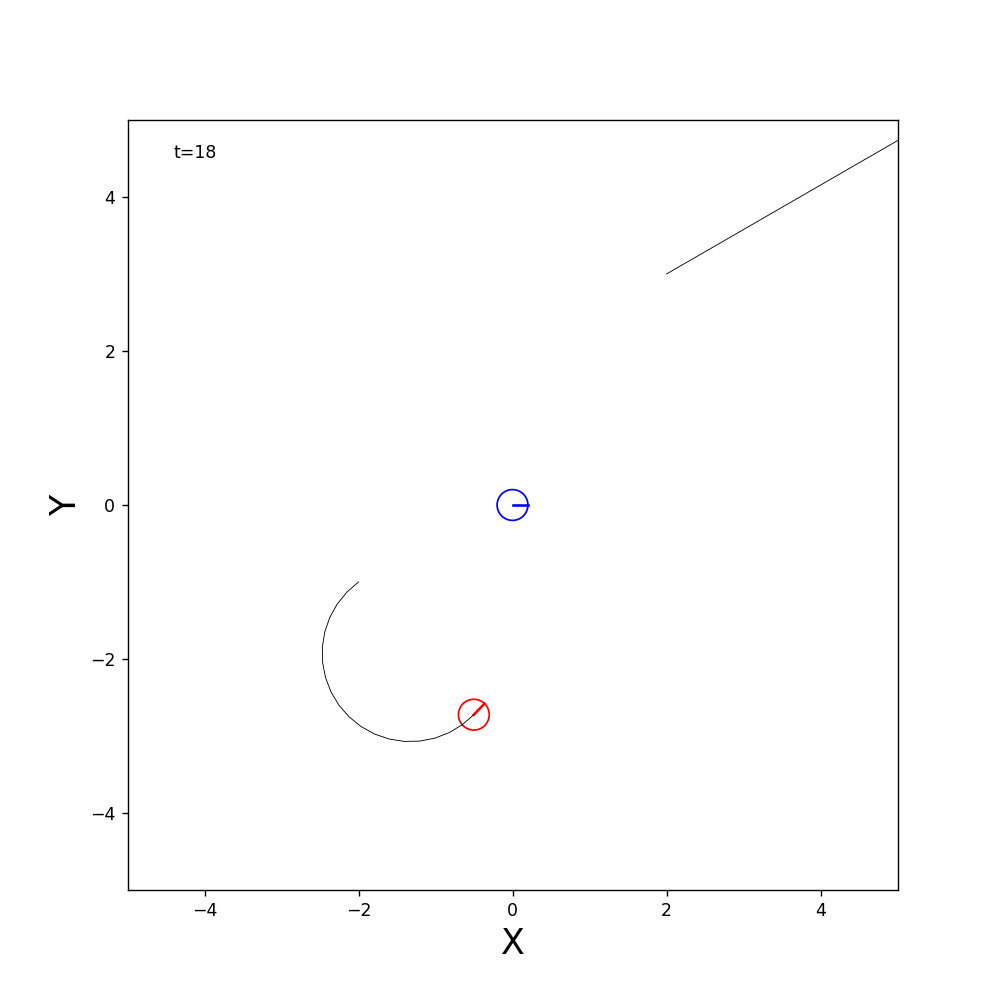

In [9]:
world = World(18,1) #何秒間シミュレーションするかと、Δtを指定
straight = Agent(0.2, 0.0) # 0.2m/sで直進させるエージェント
circling = Agent(0.2, 10.0/180*math.pi) # 0.2m/s,10deg/s で円を描く

robot1 = IdealRobot(np.array([2,3,math.pi/6]).T,straight) #ロボットのインスタンス作成（色は省略）
robot2 = IdealRobot(np.array([-2,-1,math.pi/5*6]).T,circling,"red") #ロボットのインスタンス作成（赤色指定）
robot3 = IdealRobot(np.array([0,0,0]).T,color="blue") #エージェントを与えないロボット

#ロボット登録
world.append(robot1)
world.append(robot2)
world.append(robot3)

world.draw()

In [6]:
# state_transitionをIdealRobotのオブジェクト外で使うときは、クラス名を頭に使う
## 原点から0.1m/secで1sec直進
IdealRobot.state_transition(0.1,0.0,1.0,np.array([0,0,0]).T)

array([0.1, 0. , 0. ])

In [7]:
## 原点から0.1m/sec、10deg/sで9sec直進
IdealRobot.state_transition(0.1,10/180*math.pi,9.0,np.array([0,0,0]).T)

array([0.5729578 , 0.5729578 , 1.57079633])

In [8]:
## 原点から0.1m/secで18sec直進
IdealRobot.state_transition(0.1,10/180*math.pi,18.0,np.array([0,0,0]).T)

array([7.01670930e-17, 1.14591559e+00, 3.14159265e+00])